/tmp/ipython-input-2717296891.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=f"{years}y")
[                       0%                       ]

[*********************100%***********************]  3 of 3 completed


Ticker,AAPL,MSFT,TSLA
Date,,,
2025-12-04,280.700012,480.839996,454.529999
2025-12-05,278.779999,483.160004,455.000000
2025-12-08,277.890015,491.019989,439.579987
2025-12-09,277.179993,492.019989,445.170013
2025-12-10,278.950012,478.329987,455.679901



Computing portfolio returns...
Normalized weights used:
  AAPL: 50.00%
  MSFT: 30.00%
  TSLA: 20.00%

Return summary (portfolio):


,portfolio_return
count,1255.000000
mean,0.000930
std,0.017679
min,-0.067953
1%,-0.044182
5%,-0.028643
50%,0.001361
95%,0.028767
99%,0.040871
max,0.152425



=== Computing VaR & ES for 95% confidence ===

=== Computing VaR & ES for 99% confidence ===

=== VaR Table (values are positive losses, per 1 unit of portfolio) ===


,0.95,0.99
Historical,0.028643,0.044182
Normal (param),0.028012,0.040141
t-dist (param),0.026395,0.044204
Monte Carlo,0.028088,0.040167



=== ES (CVaR) Table ===


,0.95,0.99
Historical,0.038802,0.054147
Normal (param),0.035444,0.046253
t-dist (param),0.037838,0.057759
Monte Carlo,0.035509,0.046052


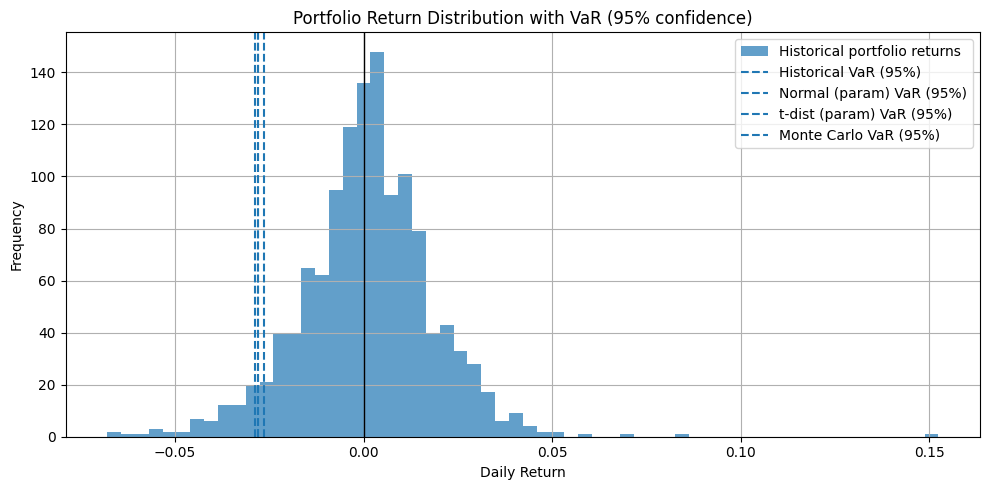

=== VaR & ES at 95% confidence ===
     Historical  VaR: 2.8643%   ES: 3.8802%
 Normal (param)  VaR: 2.8012%   ES: 3.5444%
 t-dist (param)  VaR: 2.6395%   ES: 3.7838%
    Monte Carlo  VaR: 2.8088%   ES: 3.5509%


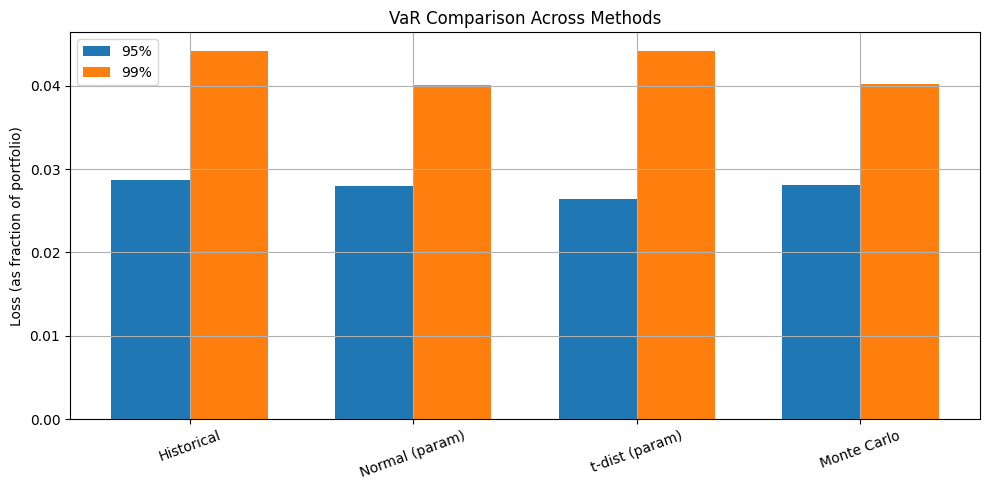

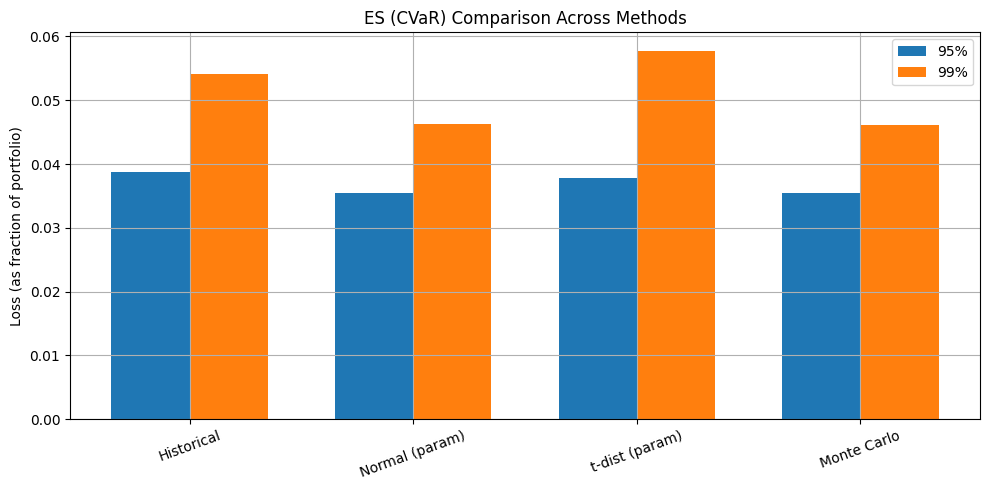

In [8]:
# ============================================================
# Portfolio VaR & Expected Shortfall (CVaR)
# ============================================================

!pip install yfinance scipy --quiet

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import t as student_t
from scipy.stats import norm

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


# ------------------------------------------------------------
# 1. Download prices & build portfolio returns
# ------------------------------------------------------------
def get_price_data(tickers, years=5):
    """
    Download daily Close prices for multiple tickers using yfinance.
    Uses 'Close' because auto_adjust=True drops 'Adj Close' in newer versions.
    """
    data = yf.download(tickers, period=f"{years}y")
    if isinstance(data, pd.DataFrame) and "Close" in data:
        prices = data["Close"]
    else:
        prices = data.copy()
        if isinstance(prices, pd.Series):
            prices = prices.to_frame(name=tickers[0])
    prices = prices.dropna(how="all")
    return prices


def compute_portfolio_returns(prices_df, weights):
    """
    Compute daily portfolio returns from price data and weights.

    prices_df : DataFrame (dates x tickers)
    weights   : array-like (len = number of tickers)
    """
    weights = np.asarray(weights, dtype=float)
    if weights.sum() != 0:
        weights = weights / weights.sum()

    # Simple returns
    asset_returns = prices_df.pct_change().dropna()  # (dates x assets)
    # Portfolio returns: r_p = sum_i (w_i * r_i)
    port_returns = asset_returns.values @ weights
    port_returns = pd.Series(port_returns, index=asset_returns.index, name="portfolio_return")
    return port_returns, asset_returns, weights


# ------------------------------------------------------------
# 2. Generic VaR / ES helper (given 1D return series)
# ------------------------------------------------------------
def historical_var_es(returns, alpha=0.95):
    """
    Historical VaR & ES for 1D returns (portfolio level).
    VaR, ES returned as positive numbers (loss magnitudes).
    """
    r = np.asarray(returns)
    # Left tail quantile
    q = np.percentile(r, (1 - alpha) * 100)
    var = -q  # VaR as positive number
    tail_losses = r[r <= q]
    if tail_losses.size == 0:
        es = var
    else:
        es = -tail_losses.mean()
    return var, es


def parametric_normal_var_es(returns, alpha=0.95, n_sim=200000, seed=0):
    """
    Parametric Normal VaR & ES via simulation (for clarity).
    Uses N(mu, sigma^2) fitted to portfolio returns.
    """
    if seed is not None:
        np.random.seed(seed)
    r = np.asarray(returns)
    mu, sigma = r.mean(), r.std(ddof=1)

    sims = np.random.normal(mu, sigma, size=n_sim)
    q = np.percentile(sims, (1 - alpha) * 100)
    var = -q
    tail_losses = sims[sims <= q]
    es = -tail_losses.mean()
    return var, es


def parametric_t_var_es(returns, alpha=0.95, n_sim=200000, seed=0):
    """
    Parametric t-distribution VaR & ES via simulation.
    Fits Student-t(df, loc, scale) to portfolio returns.
    """
    if seed is not None:
        np.random.seed(seed)
    r = np.asarray(returns)

    # Fit t-distribution parameters
    df, loc, scale = student_t.fit(r)  # MLE fit

    sims = student_t.rvs(df, loc=loc, scale=scale, size=n_sim)
    q = np.percentile(sims, (1 - alpha) * 100)
    var = -q
    tail_losses = sims[sims <= q]
    es = -tail_losses.mean()
    return var, es


def monte_carlo_portfolio_var_es(asset_returns, weights, alpha=0.95, n_sim=200000, seed=0):
    """
    Monte Carlo VaR & ES for portfolio using multivariate normal
    based on asset return mean vector & covariance matrix.

    asset_returns : DataFrame of daily returns (dates x assets)
    weights       : normalized weights (array length d)
    """
    if seed is not None:
        np.random.seed(seed)

    R = asset_returns.values
    mu_vec = R.mean(axis=0)           # daily drift per asset
    cov_mat = np.cov(R, rowvar=False) # daily covariance matrix

    d = len(weights)
    weights = np.asarray(weights)

    # Cholesky for correlated shocks
    L = np.linalg.cholesky(cov_mat)

    # Generate multivariate normal returns: shape (n_sim, d)
    Z = np.random.randn(n_sim, d)
    sims_assets = Z @ L.T + mu_vec   # mean + correlated noise
    # Portfolio simulated returns
    sims_port = sims_assets @ weights

    q = np.percentile(sims_port, (1 - alpha) * 100)
    var = -q
    tail_losses = sims_port[sims_port <= q]
    es = -tail_losses.mean()
    return var, es, sims_port


# ------------------------------------------------------------
# 3. Visualization
# ------------------------------------------------------------
def plot_portfolio_return_hist(port_returns, var_results, es_results, alpha=0.95):
    """
    Histogram of historical portfolio returns with VaR markers for each method.

    var_results: dict {method_name: VaR}
    es_results : dict {method_name: ES}
    """
    r = np.asarray(port_returns)

    plt.figure(figsize=(10, 5))
    plt.hist(r, bins=60, alpha=0.7, label="Historical portfolio returns")
    plt.axvline(0, color="black", linewidth=1)

    # Plot VaR lines: note VaR > 0 is a loss, so threshold is at -VaR
    for method, var_val in var_results.items():
        plt.axvline(-var_val, linestyle="--", label=f"{method} VaR ({alpha:.0%})")

    plt.title(f"Portfolio Return Distribution with VaR ({int(alpha*100)}% confidence)")
    plt.xlabel("Daily Return")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Optional: show ES numerically
    print(f"=== VaR & ES at {int(alpha*100)}% confidence ===")
    for method in var_results:
        print(f"{method:>15}  VaR: {var_results[method]:.4%}   ES: {es_results[method]:.4%}")


def plot_var_es_comparison(var_table, es_table, alpha_levels):
    """
    Bar chart comparison of VaR & ES by method across confidence levels.

    var_table, es_table: DataFrames with methods as index, alphas as columns
    """
    methods = var_table.index
    x = np.arange(len(methods))
    width = 0.35

    for metric_name, table in [("VaR", var_table), ("ES (CVaR)", es_table)]:
        plt.figure(figsize=(10, 5))
        offset = -width/2
        for alpha in alpha_levels:
            vals = table[alpha]
            plt.bar(x + offset, vals, width, label=f"{int(alpha*100)}%")
            offset += width

        plt.xticks(x, methods, rotation=20)
        plt.ylabel("Loss (as fraction of portfolio)")
        plt.title(f"{metric_name} Comparison Across Methods")
        plt.legend()
        plt.tight_layout()
        plt.show()


# ------------------------------------------------------------
# 4. Run everything for a sample portfolio
# ------------------------------------------------------------
if __name__ == "__main__":
    # ------------------------------
    # USER SETTINGS
    # ------------------------------
    TICKERS = ["AAPL", "MSFT", "TSLA"]     # choose your assets
    WEIGHTS = [0.5, 0.3, 0.2]              # weights for each asset
    YEARS_HISTORY = 5                      # how many years of history
    CONF_LEVELS = [0.95, 0.99]             # 95% and 99% VaR

    print(f"Downloading {YEARS_HISTORY} years of data for: {TICKERS}")
    prices = get_price_data(TICKERS, years=YEARS_HISTORY)
    display(prices.tail())

    print("\nComputing portfolio returns...")
    port_returns, asset_returns, norm_weights = compute_portfolio_returns(prices, WEIGHTS)
    print("Normalized weights used:")
    for t, w in zip(TICKERS, norm_weights):
        print(f"  {t}: {w:.2%}")

    print("\nReturn summary (portfolio):")
    display(port_returns.describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]))

    # Store results
    methods = ["Historical", "Normal (param)", "t-dist (param)", "Monte Carlo"]
    var_table = pd.DataFrame(index=methods, columns=CONF_LEVELS, dtype=float)
    es_table  = pd.DataFrame(index=methods, columns=CONF_LEVELS, dtype=float)

    # For each confidence level, compute VaR/ES via all methods
    last_mc_sims = None  # store last MC sims for plotting if needed

    for alpha in CONF_LEVELS:
        print(f"\n=== Computing VaR & ES for {int(alpha*100)}% confidence ===")
        # Historical
        h_var, h_es = historical_var_es(port_returns, alpha)
        # Parametric Normal
        n_var, n_es = parametric_normal_var_es(port_returns, alpha)
        # Parametric t
        t_var, t_es = parametric_t_var_es(port_returns, alpha)
        # Monte Carlo (multi-asset)
        mc_var, mc_es, mc_sims = monte_carlo_portfolio_var_es(asset_returns, norm_weights, alpha)
        last_mc_sims = mc_sims  # keep last set just in case

        var_table.loc["Historical", alpha]      = h_var
        es_table.loc["Historical", alpha]       = h_es
        var_table.loc["Normal (param)", alpha]  = n_var
        es_table.loc["Normal (param)", alpha]   = n_es
        var_table.loc["t-dist (param)", alpha]  = t_var
        es_table.loc["t-dist (param)", alpha]   = t_es
        var_table.loc["Monte Carlo", alpha]     = mc_var
        es_table.loc["Monte Carlo", alpha]      = mc_es

    # Show tables
    print("\n=== VaR Table (values are positive losses, per 1 unit of portfolio) ===")
    display(var_table)

    print("\n=== ES (CVaR) Table ===")
    display(es_table)

    # Plot histogram + VaR for 95% only (cleaner)
    alpha_plot = 0.95
    var_results_95 = {m: var_table.loc[m, alpha_plot] for m in methods}
    es_results_95  = {m: es_table.loc[m, alpha_plot] for m in methods}

    plot_portfolio_return_hist(port_returns, var_results_95, es_results_95, alpha=alpha_plot)

    # Compare VaR & ES across methods + confidence levels
    plot_var_es_comparison(var_table, es_table, CONF_LEVELS)
